In [3]:
import sqlite3
import pandas as pd
import json

# Connect to the SQLite database
conn = sqlite3.connect('iotaDB.db')

# Load data into a DataFrame
query = """
SELECT
    transaction_id,
    block_index,
    json(input_addresses_x) AS input_addresses,
    json(input_amounts_x) AS input_amounts,
    json(output_addresses_y) AS output_addresses,
    json(output_amounts_y) AS output_amounts,
    timestamp
FROM Transactions
"""
df = pd.read_sql(query, conn)

# Convert JSON strings back to lists (assuming they are stored as JSON strings)
df['input_addresses'] = df['input_addresses'].apply(json.loads)
df['input_amounts'] = df['input_amounts'].apply(json.loads)
df['output_addresses'] = df['output_addresses'].apply(json.loads)
df['output_amounts'] = df['output_amounts'].apply(json.loads)

# Calculate the total input and output amounts per transaction
df['total_input_amount'] = df['input_amounts'].apply(sum)
df['total_output_amount'] = df['output_amounts'].apply(sum)

# Descriptive statistics for input and output amounts
input_stats = df['total_input_amount'].describe()
output_stats = df['total_output_amount'].describe()

# Print the descriptive statistics
print("Input Amounts Descriptive Statistics:")
print(input_stats)
print("\nOutput Amounts Descriptive Statistics:")
print(output_stats)

# Close the database connection
conn.close()

Input Amounts Descriptive Statistics:
count    9.425460e+05
mean     3.897167e+11
std      4.215175e+12
min      0.000000e+00
25%      4.500000e+06
50%      4.297324e+08
75%      5.950000e+09
max      2.303012e+14
Name: total_input_amount, dtype: float64

Output Amounts Descriptive Statistics:
count    9.425460e+05
mean     4.045383e+11
std      4.339376e+12
min      9.000000e+00
25%      1.000000e+07
50%      5.000000e+08
75%      6.878873e+09
max      2.303012e+14
Name: total_output_amount, dtype: float64


first and last transaction dates in your dataset

In [1]:
import sqlite3
import pandas as pd

# Connect to the SQLite database
conn = sqlite3.connect('iotaDB.db')

# Load the transactions data from the SQLite database into a DataFrame
df = pd.read_sql_query("SELECT * FROM Transactions", conn)

# Ensure the output_timestamp column is in datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Find the first and last transactions based on the output_timestamp column
first_transaction_date = df['timestamp'].min()
last_transaction_date = df['timestamp'].max()

# Print the results
print("First transaction date:", first_transaction_date)
print("Last transaction date:", last_transaction_date)

# Close the connection
conn.close()


First transaction date: 2021-04-28 13:57:39
Last transaction date: 2022-04-28 15:59:55


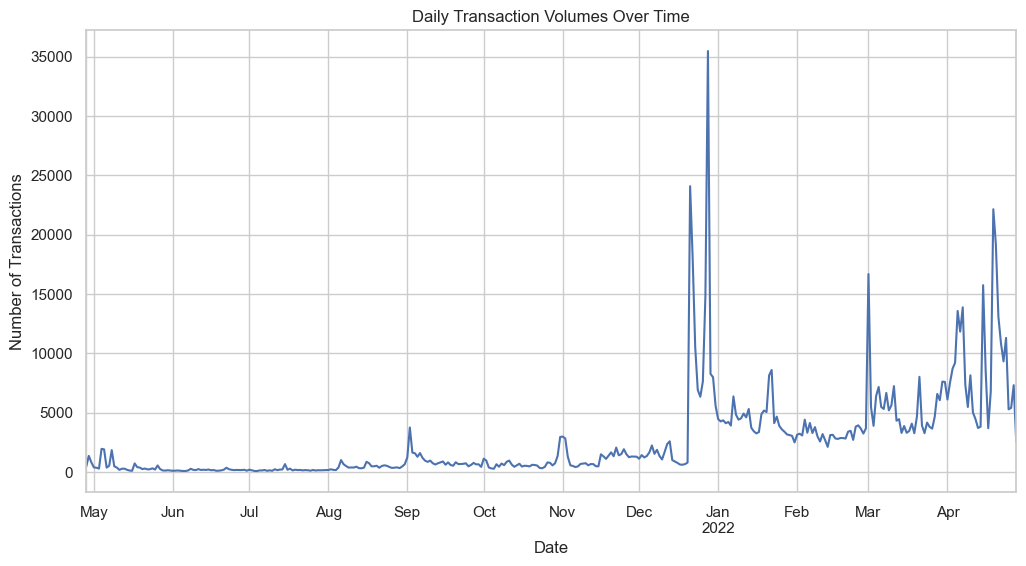

In [8]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the visual style for seaborn plots
sns.set(style="whitegrid")

# Connect to the SQLite database
conn = sqlite3.connect('iotaDB.db')

# Load data into a DataFrame
query = """
SELECT
    transaction_id,
    block_index,
    input_amounts_x AS input_amounts,
    output_amounts_y AS output_amounts,
    timestamp
FROM Transactions
"""
df = pd.read_sql(query, conn)

# Convert JSON strings back to lists and calculate the relevant fields
df['input_amounts'] = df['input_amounts'].apply(json.loads)
df['output_amounts'] = df['output_amounts'].apply(json.loads)
df['total_input_amount'] = df['input_amounts'].apply(sum)
df['total_output_amount'] = df['output_amounts'].apply(sum)

# Parse timestamps into pandas datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Transaction Volumes Over Time
plt.figure(figsize=(12, 6))
df.set_index('timestamp').resample('D')['transaction_id'].count().plot()
plt.title('Daily Transaction Volumes Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.show()



# Close the database connection
conn.close()


#  Calculate and Plot Average Transaction Value

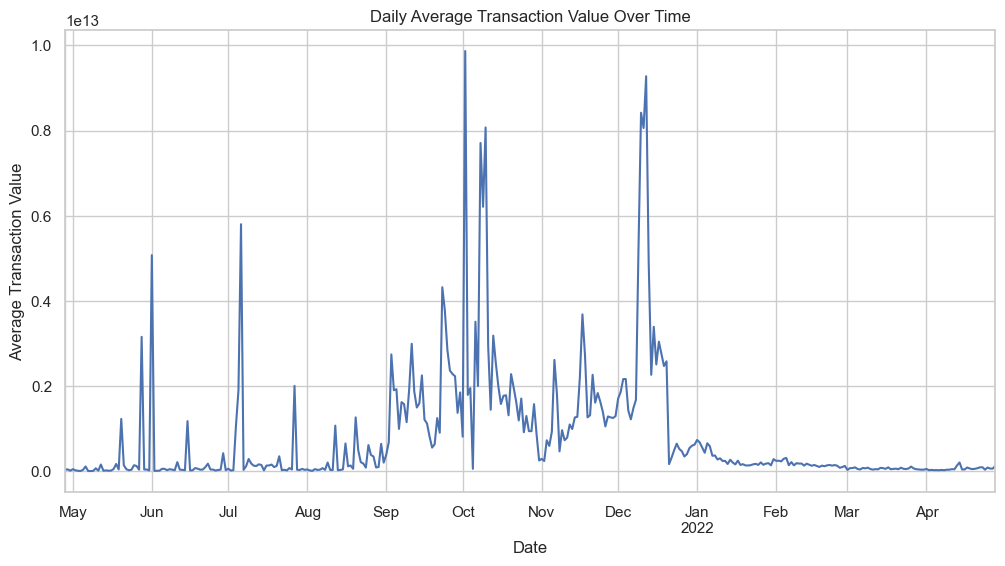

In [10]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Connect to the SQLite database
conn = sqlite3.connect('iotaDB.db')

# Load data into a DataFrame
query = """
SELECT timestamp, output_amounts_y AS output_amounts
FROM Transactions
"""
df = pd.read_sql(query, conn)

# Convert JSON strings back to lists
df['output_amounts'] = df['output_amounts'].apply(json.loads)

# Calculate total output amounts per transaction
df['total_output_amount'] = df['output_amounts'].apply(sum)

# Convert output_timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Resample to calculate daily average transaction value
df.set_index('timestamp', inplace=True)
daily_average = df.resample('D')['total_output_amount'].mean()

# Plotting the daily average transaction value
plt.figure(figsize=(12, 6))
daily_average.plot(title='Daily Average Transaction Value Over Time')
plt.xlabel('Date')
plt.ylabel('Average Transaction Value')
plt.grid(True)
plt.show()

# Close the database connection
conn.close()


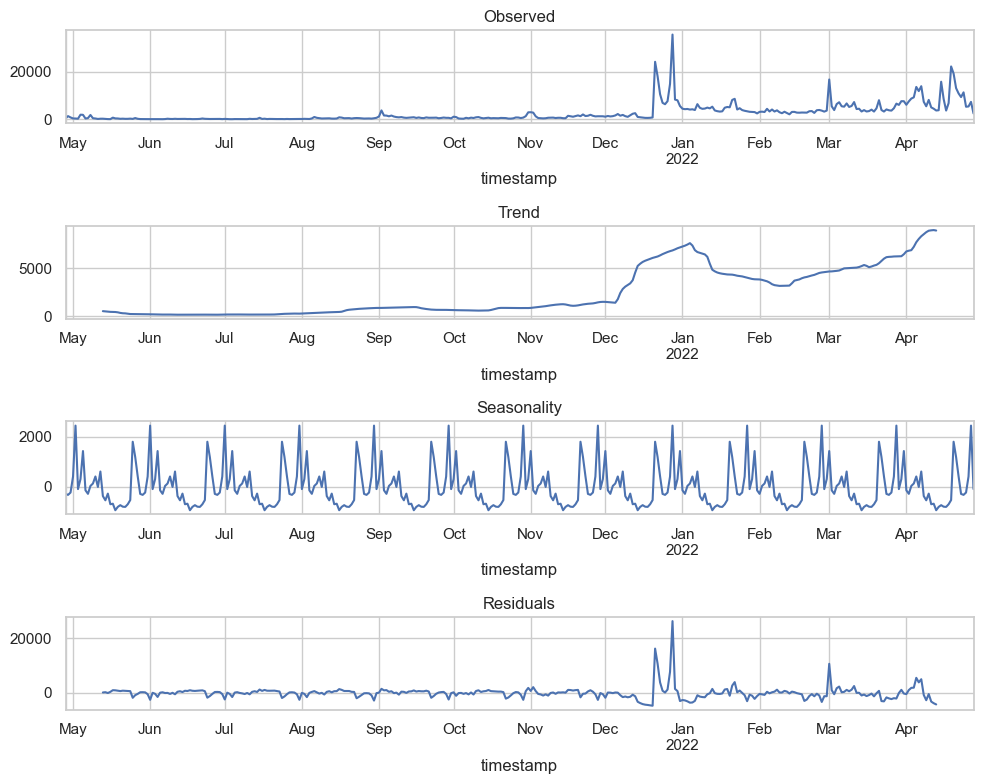

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from statsmodels.tsa.seasonal import seasonal_decompose

# Connect to the SQLite database
conn = sqlite3.connect('iotaDB.db')

# Query the database for transactions data
query = "SELECT timestamp, COUNT(transaction_id) as daily_transactions FROM Transactions GROUP BY DATE(timestamp)"
df = pd.read_sql(query, conn, parse_dates=['timestamp'], index_col='timestamp')

# Resampling to daily data
daily_transactions = df['daily_transactions'].resample('D').sum()

# Time series decomposition
result = seasonal_decompose(daily_transactions, model='additive', period=30)  # Assuming monthly seasonality

# Plotting the decomposed time series
fig, axes = plt.subplots(4, 1, figsize=(10, 8))
result.observed.plot(ax=axes[0], title='Observed')
result.trend.plot(ax=axes[1], title='Trend')
result.seasonal.plot(ax=axes[2], title='Seasonality')
result.resid.plot(ax=axes[3], title='Residuals')
plt.tight_layout()
plt.show()

# Close the database connection
conn.close()
